In [9]:
#!/usr/bin/env python3.4

import os
import sys
import re
import uuid
import random
import imageio
import numpy as np
import torch
import torch_scatter

from scipy import misc
from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt


def read(file):
    if file.endswith('.float3'): return readFloat(file)
    elif file.endswith('.flo'): return readFlow(file)
    elif file.endswith('.ppm'): return readImage(file)
    elif file.endswith('.pgm'): return readImage(file)
    elif file.endswith('.png'): return readImage(file)
    elif file.endswith('.jpg'): return readImage(file)
    elif file.endswith('.pfm'): return readPFM(file)[0]
    else: raise Exception('don\'t know how to read %s' % file)

def write(file, data):
    if file.endswith('.float3'): return writeFloat(file, data)
    elif file.endswith('.flo'): return writeFlow(file, data)
    elif file.endswith('.ppm'): return writeImage(file, data)
    elif file.endswith('.pgm'): return writeImage(file, data)
    elif file.endswith('.png'): return writeImage(file, data)
    elif file.endswith('.jpg'): return writeImage(file, data)
    elif file.endswith('.pfm'): return writePFM(file, data)
    else: raise Exception('don\'t know how to write %s' % file)

def readPFM(file):
    file = open(file, 'rb')

    color = None
    width = None
    height = None
    scale = None
    endian = None

    header = file.readline().rstrip()
    if header.decode("ascii") == 'PF':
        color = True
    elif header.decode("ascii") == 'Pf':
        color = False
    else:
        raise Exception('Not a PFM file.')

    dim_match = re.match(r'^(\d+)\s(\d+)\s$', file.readline().decode("ascii"))
    if dim_match:
        width, height = list(map(int, dim_match.groups()))
    else:
        raise Exception('Malformed PFM header.')

    scale = float(file.readline().decode("ascii").rstrip())
    if scale < 0: # little-endian
        endian = '<'
        scale = -scale
    else:
        endian = '>' # big-endian

    data = np.fromfile(file, endian + 'f')
    shape = (height, width, 3) if color else (height, width)

    data = np.reshape(data, shape)
    data = np.flipud(data)
    return data, scale

def writePFM(file, image, scale=1):
    file = open(file, 'wb')

    color = None

    if image.dtype.name != 'float32':
        raise Exception('Image dtype must be float32.')

    image = np.flipud(image)

    if len(image.shape) == 3 and image.shape[2] == 3: # color image
        color = True
    elif len(image.shape) == 2 or len(image.shape) == 3 and image.shape[2] == 1: # greyscale
        color = False
    else:
        raise Exception('Image must have H x W x 3, H x W x 1 or H x W dimensions.')

    file.write('PF\n' if color else 'Pf\n'.encode())
    file.write('%d %d\n'.encode() % (image.shape[1], image.shape[0]))

    endian = image.dtype.byteorder

    if endian == '<' or endian == '=' and sys.byteorder == 'little':
        scale = -scale

    file.write('%f\n'.encode() % scale)

    image.tofile(file)

def readFlow(name):
    if name.endswith('.pfm') or name.endswith('.PFM'):
        return readPFM(name)[0][:,:,0:2]

    f = open(name, 'rb')

    header = f.read(4)
    if header.decode("utf-8") != 'PIEH':
        raise Exception('Flow file header does not contain PIEH')

    width = np.fromfile(f, np.int32, 1).squeeze()
    height = np.fromfile(f, np.int32, 1).squeeze()

    flow = np.fromfile(f, np.float32, width * height * 2).reshape((height, width, 2))

    return flow.astype(np.float32)

def readImage(name):
    if name.endswith('.pfm') or name.endswith('.PFM'):
        data = readPFM(name)[0]
        if len(data.shape)==3:
            return data[:,:,0:3]
        else:
            return data

    return imageio.imread(name)

def writeImage(name, data):
    if name.endswith('.pfm') or name.endswith('.PFM'):
        return writePFM(name, data, 1)

    return misc.imsave(name, data)

def writeFlow(name, flow):
    f = open(name, 'wb')
    f.write('PIEH'.encode('utf-8'))
    np.array([flow.shape[1], flow.shape[0]], dtype=np.int32).tofile(f)
    flow = flow.astype(np.float32)
    flow.tofile(f)

def readFloat(name):
    f = open(name, 'rb')

    if(f.readline().decode("utf-8"))  != 'float\n':
        raise Exception('float file %s did not contain <float> keyword' % name)

    dim = int(f.readline())

    dims = []
    count = 1
    for i in range(0, dim):
        d = int(f.readline())
        dims.append(d)
        count *= d

    dims = list(reversed(dims))

    data = np.fromfile(f, np.float32, count).reshape(dims)
    if dim > 2:
        data = np.transpose(data, (2, 1, 0))
        data = np.transpose(data, (1, 0, 2))

    return data

def writeFloat(name, data):
    f = open(name, 'wb')

    dim=len(data.shape)
    if dim>3:
        raise Exception('bad float file dimension: %d' % dim)

    f.write(('float\n').encode('ascii'))
    f.write(('%d\n' % dim).encode('ascii'))

    if dim == 1:
        f.write(('%d\n' % data.shape[0]).encode('ascii'))
    else:
        f.write(('%d\n' % data.shape[1]).encode('ascii'))
        f.write(('%d\n' % data.shape[0]).encode('ascii'))
        for i in range(2, dim):
            f.write(('%d\n' % data.shape[i]).encode('ascii'))

    data = data.astype(np.float32)
    if dim==2:
        data.tofile(f)

    else:
        np.transpose(data, (2, 0, 1)).tofile(f)

def readCamInfo(file):
    # read camera info txt file, the structure is:
    # ...	
    # Frame <frame_id>\n	frame_id is the frame index. All images and data files for this frame carry this name, as a four-digit number with leading zeroes for padding.
    # L T00 T01 T02 T03 T10 ... T33\n	Camera-to-world 4x4 matrix for the left view of the stereo pair in row-major order, i.e. (T00 T01 T02 T03) encodes the uppermost row from left to right.
    # R T00 T01 T02 T03 T10 ... T33\n	Ditto for the right view of the stereo pair.
    # \n	(an empty line)
    # Frame <frame_id>\n	(the next frame's index)
    # ...	(and so on)

    cam_info = []
    with open(file, 'r') as f:
        lines = f.readlines()
        for i in tqdm(range(0, len(lines), 4), desc="Reading camera data"):
            frame_id = int(lines[i].split()[1])
            T_left = np.array(lines[i+1].split()[1:], dtype=float).reshape(4, 4)
            T_right = np.array(lines[i+2].split()[1:], dtype=float).reshape(4, 4)
            cam_info.append({
                "frame_id": frame_id,
                "left": T_left,
                "right": T_right
            })
            
    return cam_info

def RGBD2PCD(rgbs, depths, intrinsics, c2ws):
    # Assuming rgbs is of shape (N, 3, H, W), depths is of shape (N, 1, H, W), and c2ws is of shape (N, 4, 4)
    N, _, H, W = rgbs.shape
    if len(intrinsics.shape) == 2:
        intrinsics = intrinsics[None]
    intrinsics = torch.tensor(intrinsics, dtype=torch.float32, device=rgbs.device)

    with torch.no_grad():
        # Create meshgrid for x and y coordinates
        pos_x, pos_y = torch.meshgrid(torch.arange(W, device=rgbs.device), torch.arange(H, device=rgbs.device), indexing='xy')
        pos_x = pos_x.unsqueeze(0).expand(N, -1, -1)  # Shape: (N, H, W)
        pos_y = pos_y.unsqueeze(0).expand(N, -1, -1)  # Shape: (N, H, W)

        # Stack x and y coordinates and reshape to (N, H*W, 2)
        p_img = torch.stack([pos_x, pos_y], dim=-1).reshape(N, -1, 2)  # Shape: (N, H*W, 2)

        # Compute x_cam and y_cam
        x_cam = (p_img[:, :, 0] - intrinsics[:, 0, 2].unsqueeze(1)) * depths.reshape(N, -1) / intrinsics[:, 0, 0].unsqueeze(1)
        y_cam = (p_img[:, :, 1] - intrinsics[:, 1, 2].unsqueeze(1)) * depths.reshape(N, -1) / intrinsics[:, 1, 1].unsqueeze(1)

        # Stack x_cam, y_cam, depth, and ones to form homogeneous coordinates
        p_cam_homo = torch.stack([x_cam, y_cam, depths.reshape(N, -1), torch.ones_like(x_cam, device=rgbs.device)], dim=-1)  # Shape: (N, H*W, 4)

        # Transform to blender coordinate system
        p_cam_homo[:, :, 1:3] *= -1

        # Transform to world coordinates
        p_world = torch.matmul(p_cam_homo, c2ws.transpose(-2, -1))[:, :, :3]  # Shape: (N, H*W, 3)

        # Reshape rgb to (N, H*W, 3)
        rgb_world = rgbs.permute(0, 2, 3, 1).reshape(N, -1, 3)  # Shape: (N, H*W, 3)
    
    return p_world, rgb_world

def voxelization(p_world, feats, voxel_size, xyz_min=None):
    with torch.no_grad():
        # automatically determine the voxel size
        N, P, C = p_world.shape
        p_world = p_world.reshape(N*P, C)
        feats = feats.reshape(N*P, -1)
        if xyz_min is None:
            xyz_min = torch.min(p_world.reshape(-1, 3), dim=0).values
        voxel_index = torch.div(p_world - xyz_min[None, :], voxel_size[None, :], rounding_mode='floor')
        voxel_coords = voxel_index * voxel_size[None, :] + xyz_min[None, :] + voxel_size[None, :] / 2

        new_coors, unq_inv, unq_cnt = torch.unique(voxel_coords, return_inverse=True, return_counts=True, dim=0)
        feat_mean = torch_scatter.scatter(feats, unq_inv, dim=0, reduce='mean')

        new_feats = feat_mean[unq_inv]

        return new_feats

In [2]:
data_folder = "../data/sceneflow"
scene_path = "15mm_focallength/scene_backwards/fast"
stereo_sel = "left"

if "15mm" in scene_path:
    intrinsics = np.array([[450.0, 0.0, 479.5], [0.0, 450.0, 269.5], [0.0, 0.0, 1.0]])
else:
    intrinsics = np.array([[1050.0, 0.0, 479.5], [0.0, 1050.0, 269.5], [0.0, 0.0, 1.0]])

cam_info = readCamInfo(os.path.join(data_folder, "camera_data", scene_path, "camera_data.txt"))

Reading camera data: 100%|██████████| 300/300 [00:00<00:00, 61464.01it/s]


## 1. Visualize Data Sample

In [3]:
idx = random.randint(0, len(cam_info)-1)
print("Frame id:", cam_info[idx]["frame_id"])

rgb = read(os.path.join(data_folder, "frames_cleanpass", scene_path, stereo_sel, "{:04d}.png".format(cam_info[idx]["frame_id"])))
disparity = read(os.path.join(data_folder, "disparity", scene_path, stereo_sel, "{:04d}.pfm".format(cam_info[idx]["frame_id"])))
if stereo_sel == "left":
    optical_flow_past = read(os.path.join(data_folder, "optical_flow", scene_path, "into_past", stereo_sel, "OpticalFlowIntoPast_{:04d}_L.pfm".format(cam_info[idx]["frame_id"])))
    optical_flow_future = read(os.path.join(data_folder, "optical_flow", scene_path, "into_future", stereo_sel, "OpticalFlowIntoFuture_{:04d}_L.pfm".format(cam_info[idx]["frame_id"])))
else:
    optical_flow_past = read(os.path.join(data_folder, "optical_flow", scene_path, "into_past", stereo_sel, "OpticalFlowIntoPast_{:04d}_R.pfm".format(cam_info[idx]["frame_id"])))
    optical_flow_future = read(os.path.join(data_folder, "optical_flow", scene_path, "into_future", stereo_sel, "OpticalFlowIntoFuture_{:04d}_R.pfm".format(cam_info[idx]["frame_id"])))

Frame id: 164


/tmp/ipykernel_43996/2397264021.py:129: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  return imageio.imread(name)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Intrinsics of 163:
 [[450.    0.  479.5]
 [  0.  450.  269.5]
 [  0.    0.    1. ]]
Extrinsics of 163 @ left
 [[-1.19327053e-01  1.18687282e-08  9.92854834e-01  6.83811128e+01]
 [ 9.92854834e-01  1.02001579e-07  1.19327120e-01 -6.25302589e+00]
 [-3.15303303e-08  9.99999940e-01  5.30742383e-08  1.00000002e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


(-0.5, 959.5, 539.5, -0.5)

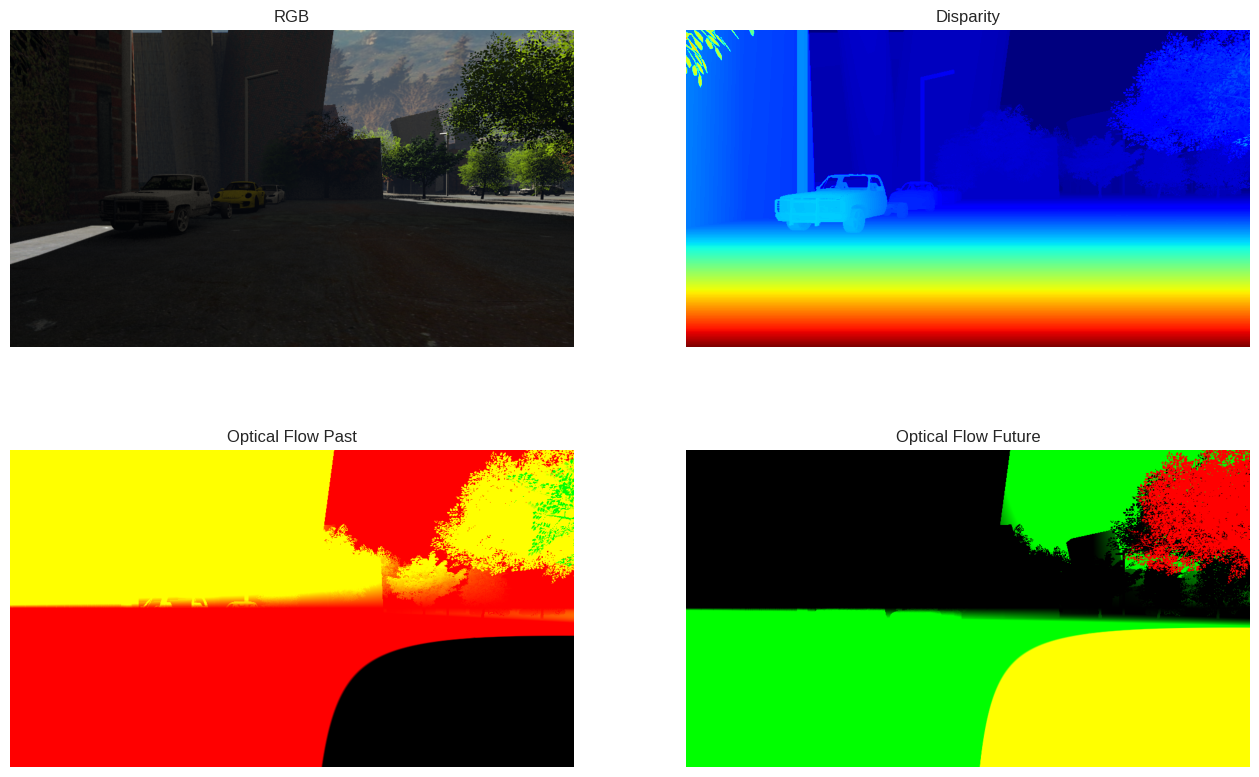

In [4]:
print(f"Intrinsics of {idx}:\n", intrinsics)
print(f"Extrinsics of {idx} @ {stereo_sel}\n", cam_info[idx][stereo_sel])
plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(16, 10))
plt.tight_layout()
plt.subplot(2, 2, 1)
plt.imshow(rgb)
plt.title("RGB")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(disparity, cmap="jet")
plt.title("Disparity")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(optical_flow_past)
plt.title("Optical Flow Past")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(optical_flow_future)
plt.title("Optical Flow Future")
plt.axis("off")

/tmp/ipykernel_43996/2397264021.py:129: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  return imageio.imread(name)


(-0.5, 959.5, 539.5, -0.5)

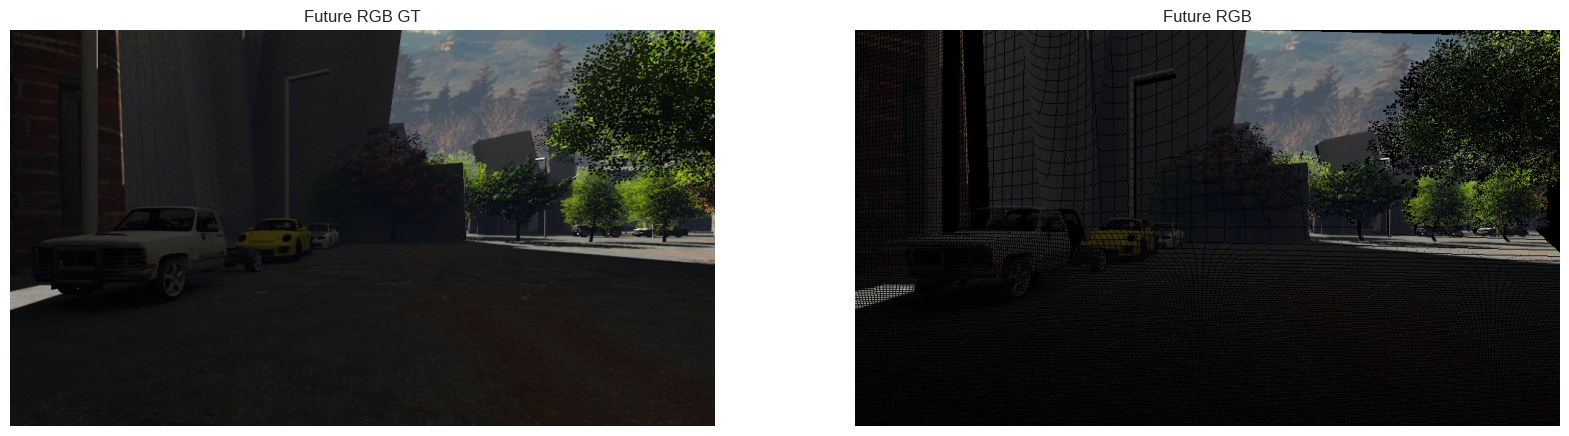

In [5]:
# wrap image to next frame
future_rgb_gt = read(os.path.join(data_folder, "frames_cleanpass", scene_path, stereo_sel, "{:04d}.png".format(cam_info[idx+1]["frame_id"])))
plt.figure(figsize=(20, 10))
plt.tight_layout()
plt.subplot(1, 2, 1)
plt.imshow(future_rgb_gt)
plt.title("Future RGB GT")
plt.axis("off")

# wrap optical flow to next frame
# The image origin (x=0,y=0) is located in the upper left corner, i.e. a flow vector of (x=10,y=10) points towards the lower right.
# Optical flow is a three-channel PFM image. Layer 0/1 contains the flow component in horizontal/vertical image direction, while layer 2 is empty (all zeroes).
future_rgb = np.zeros_like(rgb)
cur_x, cur_y = np.meshgrid(np.arange(rgb.shape[1]), np.arange(rgb.shape[0]))
x = np.int64(cur_x + optical_flow_future[:, :, 0])
y = np.int64(cur_y + optical_flow_future[:, :, 1])
mask = (x >= 0) & (x < rgb.shape[1]) & (y >= 0) & (y < rgb.shape[0])
future_rgb[y[mask], x[mask]] = rgb[cur_y[mask], cur_x[mask]]

plt.subplot(1, 2, 2)
plt.imshow(future_rgb)
plt.title("Future RGB")
plt.axis("off")

/tmp/ipykernel_43996/2397264021.py:129: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  return imageio.imread(name)


(-0.5, 959.5, 539.5, -0.5)

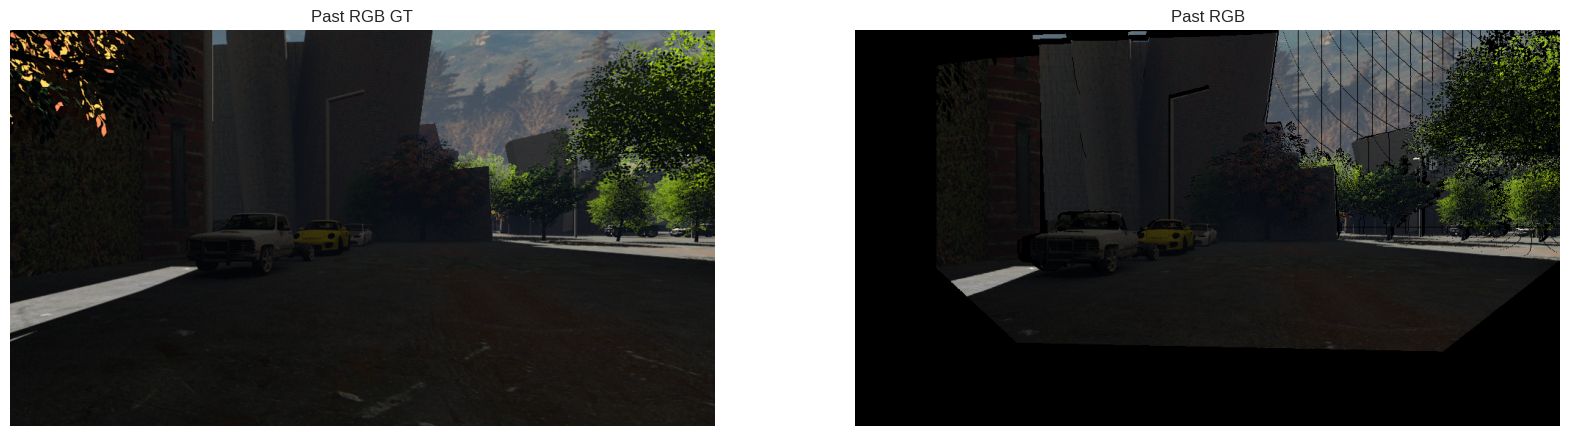

In [6]:
# wrap image to previous frame
past_rgb_gt = read(os.path.join(data_folder, "frames_cleanpass", scene_path, stereo_sel, "{:04d}.png".format(cam_info[idx-1]["frame_id"])))
plt.figure(figsize=(20, 10))
plt.tight_layout()
plt.subplot(1, 2, 1)
plt.imshow(past_rgb_gt)
plt.title("Past RGB GT")
plt.axis("off")

# wrap optical flow to previous frame
past_rgb = np.zeros_like(rgb)
cur_x, cur_y = np.meshgrid(np.arange(rgb.shape[1]), np.arange(rgb.shape[0]))
x = np.int64(cur_x + optical_flow_past[:, :, 0])
y = np.int64(cur_y + optical_flow_past[:, :, 1])
mask = (x >= 0) & (x < rgb.shape[1]) & (y >= 0) & (y < rgb.shape[0])
past_rgb[y[mask], x[mask]] = rgb[cur_y[mask], cur_x[mask]]

plt.subplot(1, 2, 2)
plt.imshow(past_rgb)
plt.title("Past RGB")
plt.axis("off")

## 2. Generate Point Cloud and Execute Voxelization

In [54]:
device = "cuda" if torch.cuda.is_available() else "cpu"
rgbs, depths, c2ws = [], [], []
for i in tqdm(range(len(cam_info)), desc="Loading Data"):
    rgb = read(os.path.join(data_folder, "frames_cleanpass", scene_path, stereo_sel, "{:04d}.png".format(cam_info[i]["frame_id"])))
    disparity = read(os.path.join(data_folder, "disparity", scene_path, stereo_sel, "{:04d}.pfm".format(cam_info[i]["frame_id"])))
    depth = (intrinsics[0, 0]* 1.0 / disparity)
    c2w = cam_info[i][stereo_sel]

    rgbs.append(torch.tensor(rgb, dtype=torch.float32, device=device).permute(2, 0, 1))
    depths.append(torch.tensor(depth[None], dtype=torch.float32, device=device))
    c2ws.append(torch.tensor(c2w, dtype=torch.float32, device=device))

rgbs = torch.stack(rgbs, dim=0)
depths = torch.stack(depths, dim=0)
c2ws = torch.stack(c2ws, dim=0)
N, _, H, W = rgbs.shape

Loading Data:   0%|          | 0/300 [00:00<?, ?it/s]/tmp/ipykernel_65632/1141512558.py:131: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  return imageio.imread(name)
Loading Data:  20%|██        | 61/300 [00:01<00:04, 49.19it/s]

Loading Data: 100%|██████████| 300/300 [00:06<00:00, 48.91it/s]


In [55]:
# Assuming rgb is of shape (N, 3, H, W), depth is of shape (N, 1, H, W), and c2w is of shape (N, 4, 4)
p_world, rgb_world = RGBD2PCD(rgbs, depths, intrinsics, c2ws)  # Shape: (N, H*W, 3), (N, H*W, 3)
del depths, c2ws

In [56]:
# voxelization
voxel_size = torch.tensor([0.1] * 3, dtype=p_world.dtype, device=p_world.device)
rgb_world = voxelization(p_world, rgb_world, voxel_size).reshape(N, H, W, 3).cpu().numpy()
rgbs = rgbs.permute(0, 2, 3, 1).cpu().numpy()

(-0.5, 959.5, 539.5, -0.5)

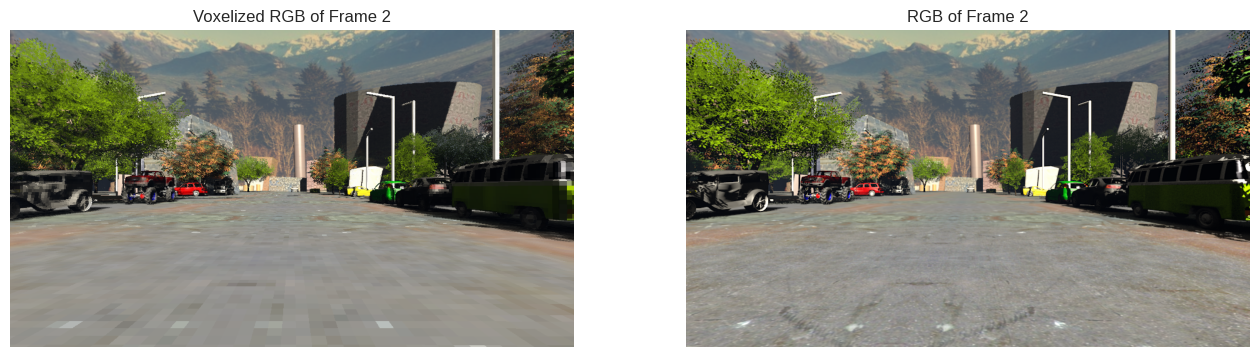

In [57]:
plt.style.use("seaborn-v0_8-whitegrid")
# idx = random.randint(0, N-1)
idx = 2
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(rgb_world[idx] / 255.0)
plt.title(f"Voxelized RGB of Frame {idx}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(rgbs[idx] / 255.0)
plt.title(f"RGB of Frame {idx}")
plt.axis("off")

In [58]:
# interval = 50
# plt.style.use("seaborn-v0_8-whitegrid")
# plt.figure()
# pcd_xyz = p_world.reshape(-1, 3).cpu().numpy()
# pcd_rgb = rgb_world.reshape(-1, 3).cpu().numpy()
# plt.scatter(pcd_xyz[::interval, 0], pcd_xyz[::interval, 1], c=np.float64(pcd_rgb[::interval]) / 255.0, s=0.1)
# plt.xlim(60, 110)
# plt.ylim(60, 100)
# plt.show()

In [59]:
# from plyfile import PlyData, PlyElement
# # 确保输入数组形状正确
# assert pcd_xyz.shape[0] == pcd_rgb.shape[0], "坐标和颜色数组的点数量不一致"
# assert pcd_xyz.shape[1] == 3, "坐标数组应为(N, 3)"
# assert pcd_rgb.shape[1] == 3, "颜色数组应为(N, 3)"

# # 转换颜色到uint8（假设颜色值在0-255或0-1范围内）
# if pcd_rgb.dtype != np.uint8:
#     if np.max(pcd_rgb) <= 1.0:
#         pcd_rgb = (pcd_rgb * 255).astype(np.uint8)
#     else:
#         pcd_rgb = pcd_rgb.astype(np.uint8)

# # 创建结构化数组
# vertex_dtype = [('x', 'f4'), ('y', 'f4'), ('z', 'f4'),
#                 ('red', 'u1'), ('green', 'u1'), ('blue', 'u1')]
# vertices = np.empty(pcd_xyz.shape[0], dtype=vertex_dtype)

# # 填充数据
# vertices['x'] = pcd_xyz[:, 0].astype('f4')
# vertices['y'] = pcd_xyz[:, 1].astype('f4')
# vertices['z'] = pcd_xyz[:, 2].astype('f4')
# vertices['red'] = pcd_rgb[:, 0]
# vertices['green'] = pcd_rgb[:, 1]
# vertices['blue'] = pcd_rgb[:, 2]

# # 生成并保存PLY文件
# ply_element = PlyElement.describe(vertices, 'vertex')
# PlyData([ply_element]).write('colored_point_cloud.ply')